Ejemplo tomado de:
    https://towardsdatascience.com/genetic-algorithms-in-python-using-the-deap-library-e67f7ce4024c

Un ejemplo de como aplicar la optimizacion con AGs 

Cuando se esta optimizando un plan de alimentacion, hay muchsa cosa que se deben tener en cuenta. En este ejemplo, se va hacer un plan de semanal de alimentacion para una persona que ya decidio cuantas calorias desea consumir y que porcentaje debe obtener de proteinas, carbohidratos y grasa.

Ademas de estos valore fijos, el programa de optimizacion tambien necesita una lista predefinida de productos para escoger. Para cada uno de esos productos, sabemos el numero de calorias por unidad, asi como tambien los porcentajes de grasa, proteinas y carbohidratos.


Las metas de cantidades para la persona de nuestro ejemplo son:
    
Total calorias= 2500 * 7 dias = 17500 calorias
Percentaje Proteina = 30%
Percentaje Carbohidratos = 50%
Percentaje Grasa = 20%

La lista de los productos de los cuales se puede escoger son:

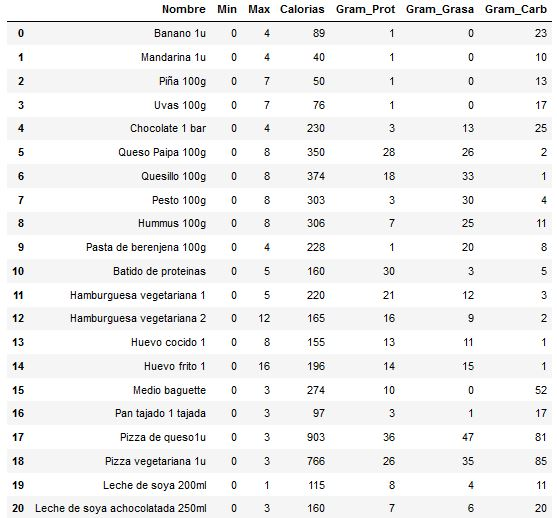

La meta de la optimizacion

La meta del programa de optimizacion es encontrar una lista de productos para la semana, de los cuales las calorias y los macronutrientes del total semanal sea tan cercano como sea posible a las cantidades de la meta.

Genetic Algorithms for optimization

Many optimization algorithms exist and Genetic Algorithms are one of them. Genetic Algorithms are fascinating because the idea behind them is very intriguing: Genetic Algorithms are based on the idea of natural selection in genetics.

Applying Genetic Algorithms to other optimizations

For other use cases of optimization, Genetic Algorithms implement the same approach of iterative mating, mutation, and selection. Rather than using a sequence of genes as an individual, it can be many other things.

In the example of optimizing meal plan, for example, we can write the “shopping list” as an individual. Buying 1000 bananas and nothing else would be a relatively bad shopping list. Buying 10 of every item would be much more realistic already.

Genetic Algorithms in Python

Sounds amazing, let’s do a practical case in Python. We will use the DEAP library, because it has a lot of genetic functions that we can reuse. You can follow along with the total notebook over here.
Set up inputs in Python

First, let’s fix the goal nutriment quantities. I’ve set them in different ways because in practice they are often expressed in percentage per nutriment, but for the optimization, it’s easier to have them in grams.

In [1]:
import pandas as pd
import numpy as np
import random
from deap import base
from deap import creator
from deap import tools

In [2]:
#porcentajes meta
total_calories = 2500 * 7
percentage_prot = 0.3
percentage_carb = 0.5
percentage_fat = 0.2

# calcula el total de calorias por macronutriente
cal_prot = round(percentage_prot * total_calories)
cal_carb = round(percentage_carb * total_calories)
cal_fat = round(percentage_fat * total_calories)
print("calorias de proteina: ",cal_prot,"calorias de carb: ",cal_carb,"calorias de grasa: ",cal_fat)

# fija la informacion sobre macronutriments: calorias por gramo de proteina, carb and grasa
prot_cal_p_gram = 4
carb_cal_p_gram = 4
fat_cal_p_gram = 9

#gramos de la meta
gram_prot = cal_prot / prot_cal_p_gram
gram_carb = cal_carb / carb_cal_p_gram
gram_fat = cal_fat / fat_cal_p_gram
print("gramos de proteina: ", gram_prot,"gramos de carb: ",gram_carb,"gramos de grasa: ",gram_fat)

calorias de proteina:  5250 calorias de carb:  8750 calorias de grasa:  3500
gramos de proteina:  1312.5 gramos de carb:  2187.5 gramos de grasa:  388.8888888888889


La segunda cosa que debemos hacer es crear la tabla de productos

# Conformamos DEAP toolbox en Python para nuestro ejemplo especifico.

Diseño de la conformacion DEAP toolbox

Ahora viene la parte mas dificil, que es conformar el toolbox DEEAP para nuestro ejemplo. Se debe especificar que forma tendra su cromosoma: la forma mas facil es una lista

En este caso, hay que escoger una lista de longitud 21, debido a que hay 21 productos en la tabla. Luego se sabe que el primer elemento es el numero de bananos, el segundo elemento es el numero de mandarinas, etc. 

# Sintaxis para conformar el toolbox de DEAP

Lo que se sabe no es visible en el individuo, el algoritmo no tiene que saberlo. Como se ve abajo, el individuo se crea usando creator.create, dnde se especifica como lista, pero ademas con una aptitud. Esta aptitud se define como FitnessMin.  

Aun no se ha llenado el individuo. Se llena donde la funcion “individual” se registra en el toolbox. El individuo se basa en una funcion n_per_product, que devuelve una lista con 21 numeros aleatorios: asi se pueden reconocer las cantidades por producto.  

La poblacion simplemente se registra como una lista de individuos.

La funcion de evaluacion es la que se define, que es la diferencia absoluta entre el numero de calorias de la lista de compra total contra el numero meta de calorias. Es relativamente facil agregar las otras cantidades a esto, como se puede ver en el notebook.

In [3]:
# por semana: min, max, cal/unidad, g de prot, g de grasa, g de carb 
products_table = pd.DataFrame.from_records([
    ['Banano 1u', 0, 4, 89, 1, 0, 23],
    ['Mandarina 1u', 0, 4, 40, 1, 0, 10],
    ['Piña 100g', 0, 7, 50, 1, 0, 13],
    ['Uvas 100g', 0, 7, 76, 1, 0, 17],
    ['Chocolate 1 bar', 0, 4, 230, 3, 13, 25],
    
    ['Queso Paipa 100g', 0, 8, 350, 28, 26, 2],
    ['Quesillo 100g', 0, 8, 374, 18, 33, 1],
    ['Pesto 100g', 0, 8, 303, 3, 30, 4],
    ['Hummus 100g', 0, 8, 306, 7, 25, 11],
    ['Pasta de berenjena 100g', 0, 4, 228, 1, 20, 8],
    
    ['Batido de proteinas', 0, 5, 160, 30, 3, 5],
    ['Hamburguesa vegetariana 1', 0, 5, 220, 21, 12, 3],
    ['Hamburguesa vegetariana 2', 0, 12, 165, 16, 9, 2],
    ['Huevo cocido 1', 0, 8, 155, 13, 11, 1],
    ['Huevo frito 1', 0, 16, 196, 14, 15, 1],
    
    ['Medio baguette', 0, 3, 274, 10, 0, 52],
    ['Pan tajado 1 tajada', 0, 3, 97, 3, 1, 17],
    ['Pizza de queso1u', 0, 3, 903, 36, 47, 81],
    ['Pizza vegetariana 1u', 0, 3, 766, 26, 35, 85],
    
    ['Leche de soya 200ml', 0, 1, 115, 8, 4, 11],
    ['Leche de soya achocolatada 250ml', 0, 3, 160, 7, 6,20],
    
])
products_table.columns = ['Nombre', 'Min', 'Max', 'Calorias', 'Gram_Prot', 'Gram_Grasa', 'Gram_Carb']

products_table

,Nombre,Min,Max,Calorias,Gram_Prot,Gram_Grasa,Gram_Carb
0,Banano 1u,0,4,89,1,0,23
1,Mandarina 1u,0,4,40,1,0,10
2,Piña 100g,0,7,50,1,0,13
3,Uvas 100g,0,7,76,1,0,17
4,Chocolate 1 bar,0,4,230,3,13,25
5,Queso Paipa 100g,0,8,350,28,26,2
6,Quesillo 100g,0,8,374,18,33,1
7,Pesto 100g,0,8,303,3,30,4
8,Hummus 100g,0,8,306,7,25,11
9,Pasta de berenjena 100g,0,4,228,1,20,8


In [4]:
# extrae la informacion de los products en un format mas facil
# para usar en la funcion de costo de los algoritmos deap 
cal_data = products_table[['Gram_Prot', 'Gram_Grasa', 'Gram_Carb']]

prot_data = list(cal_data['Gram_Prot'])
fat_data = list(cal_data['Gram_Grasa'])
carb_data = list(cal_data['Gram_Carb'])

In [6]:
# Aqui se hace la iniciacion aleatoria del AG
# da una lista de enteros con el numero de unidades para cada producto 
def n_per_product():
    return random.choices( range(0, 10), k = 21)

In [8]:
# Esta es la funcion de aptitud para la evalucion de cada lista, o individuo
# Se tomo como la diferencia absoluta entre el numero de calorias planeadas y la meta de calorias

def evaluate(individual):
    individual = individual[0]
    tot_prot = sum(x*y for x,y in zip(prot_data,individual))
    tot_fat = sum(x*y for x,y in zip(fat_data,individual))
    tot_carb = sum(x*y for x,y in zip(carb_data,individual))
    cals = prot_cal_p_gram * tot_prot + carb_cal_p_gram * tot_carb + fat_cal_p_gram * tot_fat
    return abs(cals - total_calories),

In [9]:
# Aqui se conforma el algoritmo con la libreria deap:
# se registran las diferentes funciones en el toolbox

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register("n_per_product", n_per_product)

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.n_per_product, n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

Las funciones de cruce,  mutacion y  seleccion se toman directamente de la libreria DEAP. 

In [10]:
toolbox.population(n=10)

[[[8, 8, 6, 2, 8, 5, 0, 4, 5, 0, 3, 4, 3, 2, 1, 3, 3, 0, 1, 4, 7]],
 [[9, 1, 4, 8, 7, 4, 7, 4, 7, 8, 8, 8, 3, 9, 7, 5, 7, 4, 8, 5, 5]],
 [[0, 5, 9, 0, 4, 7, 7, 9, 5, 6, 6, 8, 8, 3, 0, 4, 7, 6, 8, 7, 5]],
 [[0, 8, 3, 7, 1, 9, 6, 7, 5, 2, 0, 7, 2, 4, 5, 6, 5, 5, 0, 5, 3]],
 [[5, 9, 3, 5, 4, 9, 0, 2, 9, 8, 5, 4, 7, 2, 6, 7, 5, 7, 1, 6, 3]],
 [[6, 2, 0, 3, 1, 5, 4, 6, 0, 6, 0, 7, 4, 4, 0, 7, 3, 1, 3, 9, 2]],
 [[4, 9, 1, 2, 5, 6, 4, 7, 6, 5, 7, 8, 4, 6, 3, 1, 7, 4, 5, 4, 9]],
 [[0, 1, 2, 2, 2, 1, 0, 9, 4, 1, 1, 6, 6, 2, 9, 8, 3, 6, 9, 4, 2]],
 [[7, 4, 6, 3, 9, 8, 0, 3, 3, 7, 7, 0, 1, 6, 0, 9, 5, 5, 9, 5, 2]],
 [[2, 2, 8, 4, 2, 2, 6, 9, 1, 2, 1, 2, 1, 1, 4, 9, 6, 3, 7, 2, 3]]]

# Ciclo de optimizacion

La siguiente funcion hace la optimizacion. 
Es casi literalmente la copia de la lista de ejemplos de DEAP. Se hizo una adaptacion minima.

In [11]:
# Esta es la definicion de todo el algoritmo genetico

def main():
    pop = toolbox.population(n=300)
    
    # Evalua toda la poblacion
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    # CXPB  es la probabilidad con la que se cruzan dos individuos 
    #
    # MUTPB es la probabilidad de mutacion de un individuo
    CXPB, MUTPB = 0.5, 0.2
    
    # Se encuentran todas las aptitudes 
    fits = [ind.fitness.values[0] for ind in pop]
    
    # Variable que lleva el numero de generaciones
    g = 0
    
    # Inicia la evolucion
    while g < 5000:
        # Una nueva generacion
        g = g + 1
        #print("-- Generacion %i --" % g)
        
        # Selecciona los individuos para la siguiente generacion
        offspring = toolbox.select(pop, len(pop))
        # Clona los individuos seleccionados
        offspring = list(map(toolbox.clone, offspring))
        
        # Aplica el cruce y la mutacion a la decendencia
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1[0], child2[0])
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant[0])
                del mutant.fitness.values
            
        # Evalua los individuos con una funcion de aptitud invalida
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
            
        pop[:] = offspring
        
        # Recoge todas las aptitudes en una lista e imprime los estados 
        fits = [ind.fitness.values[0] for ind in pop]
        
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        
        #print(min(fits), max(fits), mean, std)
    
    best = pop[np.argmin([toolbox.evaluate(x) for x in pop])]
    return best

# Resultado del AG


El mejor individuo,de la ultima generacion es al lista que se muestra abajo como la columna The best individual of the last generation is the list that is shown below as the column “escog_univariada”.

In [12]:
best_solution = main()

In [13]:
products_table['escog_univariada'] = pd.Series(best_solution[0])
products_table.head()

,Nombre,Min,Max,Calorias,Gram_Prot,Gram_Grasa,Gram_Carb,escog_univariada
0,Banano 1u,0,4,89,1,0,23,1
1,Mandarina 1u,0,4,40,1,0,10,8
2,Piña 100g,0,7,50,1,0,13,2
3,Uvas 100g,0,7,76,1,0,17,0
4,Chocolate 1 bar,0,4,230,3,13,25,3


Optimizacion Multivariada

Hasta ahora, unicamente hemos optimzado el numero de calorias, sin tener en cuenta si son principalmente proteinas, grasas, o carbohidratos que estan lejos del objetivo. DEAP tiene la posibilidad de moverse muy facilmente de optimizacion de objetivo unico a optimizacion multi-objetivos. 

La unica cosa que cambia en el codigo es la funcion de evaluacion, que ahora debe retornar una tupla de los cuatro valores (error en termnos de calorias, error en terminos de proteinas, error en terminos de grasas y error en terminos de carbohidratos) y la adicion de un vector ponderado para balancear los psesos de cada uno de ellos.

In [14]:
# En esta segunda version, se optimiza para los cuatro componentes de la lista
# de compras: calorias, proteinas, grasas y carbohidratos, 
# Es necesario darle valor a cada cosa, para eso se le agrega un peso.
# Sabemos que hay 30% de calorias en proteinas, 20% de calorias en grasas y 
# 50% de calorias en carbohidratos.
weights = (-1., -1. / 0.3, -1. / 0.2, -1./0.5)

In [15]:
creator.create("FitnessMin", base.Fitness, weights=weights)
creator.create("Individual", list, fitness=creator.FitnessMin)

C:\Users\UsuariosJ\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\UsuariosJ\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [16]:
def evaluate(individual):
    individual = individual[0]
    tot_prot = sum(x*y for x,y in zip(prot_data,individual))
    tot_fat = sum(x*y for x,y in zip(fat_data,individual))
    tot_carb = sum(x*y for x,y in zip(carb_data,individual))
    cals = prot_cal_p_gram * tot_prot + carb_cal_p_gram * tot_carb + fat_cal_p_gram * tot_fat
    
    
    return abs(cals - total_calories), abs(tot_prot - gram_prot), \
           abs(tot_fat - gram_fat), abs(tot_carb - gram_carb)

In [17]:
# Aqui se conforma el algoritmo con la libreria deap:
# se registran las diferentes funciones en el toolbox

toolbox = base.Toolbox()

toolbox.register("n_per_product", n_per_product)

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.n_per_product, n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Optimizacion Uni-objectivo vs optimzizacion multi-objectivo

Es interesante observar los resultados de las optimizationes uni-objectivo and multi-objectivo optimizations adicionales. In the caso de los pesos corrientes usad, it gives the following:

    Calcula un error para cada uno de los cuatro objetivos, vemos que el error total de la solucion multivariada es mejor
    Tambien vemos que la distribucion del error es diferente. Se podria ajustar mas añadiendo mas peso a las proteinas, por ejemplo, si  en terminos de proteinas es mas importante.

In [18]:
def main():
    pop = toolbox.population(n=300)
    
    # Evalua toda la poblacion
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    # CXPB  es la probabilidad con la que se cruzan dos individuos 
    #
    # MUTPB es la probabilidad de mutacion de un individuo
    CXPB, MUTPB = 0.5, 0.2
    
    # Se encuentran todas las aptitudes 
    fits = [ind.fitness.values[0] for ind in pop]
    
    # Variable que lleva el numero de generaciones
    g = 0
    
    # Inicia la evolucion
    while g < 5000:
        # Una nueva generacion
        g = g + 1
        #print("-- Generacion %i --" % g)
        
        # Selecciona los individuos para la siguiente generacion
        offspring = toolbox.select(pop, len(pop))
        # Clona los individuos seleccionados
        offspring = list(map(toolbox.clone, offspring))
        
        # Aplica el cruce y la mutacion a la decendencia
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1[0], child2[0])
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant[0])
                del mutant.fitness.values
            
                
        # Evalua los individuos con una funcion de aptitud invalida
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
            
        pop[:] = offspring
        
        
        # Recoge todas las aptitudes en una lista e imprime los estados
        fits = [ind.fitness.values[0] for ind in pop]
        
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        
        #print(min(fits), max(fits), mean, std)
    
    
    best = pop[np.argmin([sum(toolbox.evaluate(x)) for x in pop])]
    return best

In [19]:
best_solution = main()

In [20]:
products_table['escog_multivariada'] = pd.Series(best_solution[0])

Analisis de resultados

In [21]:
products_table['univariado_gr_prot'] = products_table['escog_univariada'] * products_table['Gram_Prot']
products_table['univariado_gr_grasa'] = products_table['escog_univariada'] * products_table['Gram_Grasa']
products_table['univariado_gr_carb'] = products_table['escog_univariada'] * products_table['Gram_Carb']
products_table['univariado_cal'] = products_table['escog_univariada'] * products_table['Calorias']

products_table['multivariado_gr_prot'] = products_table['escog_multivariada'] * products_table['Gram_Prot']
products_table['multivariado_gr_grasa'] = products_table['escog_multivariada'] * products_table['Gram_Grasa']
products_table['multivariado_gr_carb'] = products_table['escog_univariada'] * products_table['Gram_Carb']
products_table['multivariado_cal'] = products_table['escog_univariada'] * products_table['Calorias']

Resumen de los resultados univariado y multivariado

In [22]:
summary = pd.DataFrame.from_records(
[
    [products_table['univariado_gr_prot'].sum(), products_table['multivariado_gr_prot'].sum(), gram_prot],
    [products_table['univariado_gr_grasa'].sum(), products_table['multivariado_gr_grasa'].sum(), gram_fat],
    [products_table['univariado_gr_carb'].sum(), products_table['multivariado_gr_carb'].sum(), gram_carb],
    [products_table['univariado_cal'].sum(), products_table['multivariado_cal'].sum(), sum((cal_prot, cal_carb, cal_fat))]
])
summary.columns = ['univariado', 'multivariado', 'meta']
summary.index = ['prot', 'grasa', 'carb', 'cal']
summary["univ_error"] = (summary["meta"] - summary["univariado"]).apply(abs)
summary["multiv_error"] = (summary["meta"] - summary["multivariado"]).apply(abs)
summary

,univariado,multivariado,meta,univ_error,multiv_error
prot,922,999,1312.500000,390.500000,313.500000
grasa,1021,1048,388.888889,632.111111,659.111111
carb,1155,1155,2187.500000,1032.500000,1032.500000
cal,17828,17828,17500.000000,328.000000,328.000000


In [21]:
summary["univ_error"].sum(), summary["multiv_error"].sum()

(1985.111111111111, 2250.1111111111113)

In [22]:
# Lista de compras
products_table[['Nombre', 'escog_multivariada', 'escog_univariada']]

,Nombre,escog_multivariada,escog_univariada
0,Banano 1u,5,9
1,Mandarina 1u,2,6
2,Piña 100g,9,0
3,Uvas 100g,9,2
4,Chocolate 1 bar,6,7
5,Queso Paipa 100g,2,3
6,Quesillo 100g,6,9
7,Pesto 100g,5,0
8,Hummus 100g,0,4
9,Pasta de berenjena 100g,2,0


Al final, la tabla de productos siempre va a ser el factor limitante: en algun punto, sera imposible enconrar una combinacion de productos especificos que alcance el objetivo perfectamente. para tener una mejor solucion, se tendrian que agregar mas productos a la tabla. 

# Conclusion

Ejemplo tomado de:
    https://towardsdatascience.com/genetic-algorithms-in-python-using-the-deap-library-e67f7ce4024c